In [1]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation

# Anomaly Detection 2

As before, the devices in the dataset have 4 different engines which have to compress a gas to chill or heat the environment. The percentage of working/loading of those units is extremely important due to it could indicate problems related to under-dimensioned or over-dimensioned devices, deterioration of some mechanical parts, or not suitable external environment conditions. For this point, the task is:
- Identify some possible correlations between the percentage of device loading and the external temperature

## 1. PySpark Inizialization

In [2]:
# import the python libraries to create/connect to a Spark Session
from pyspark.sql import SparkSession

# build a SparkSession 
#   connect to the master node on the port where the master node is listening (7077)
#   declare the app name 
#   configure the executor memory to 512 MB
#   either *connect* or *create* a new Spark Context
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("My first spark application")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/07/05 12:25:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
df = spark.read.load("5aeff182-52ab-46d3-af1d-57ac75b3a21e.csv",format="csv", sep=",", inferSchema="true", header="true")
df.show()

+-------------+------+------+-----+
|         when|  hwid|metric|value|
+-------------+------+------+-----+
|1601510485159|SW-065|   SA4|    0|
|1601510485159|SW-065|   SA3|    0|
|1601510485159|SW-065|   SA2|    0|
|1601510485159|SW-065|   S34|    0|
|1601510485159|SW-065|   S33|    1|
|1601510485159|SW-065|   S25|    0|
|1601510485159|SW-065|   S19|    0|
|1601510485159|SW-065|   S17|    0|
|1601510485159|SW-065|   S16|    0|
|1601510485159|SW-065|   S15|    0|
|1601510485159|SW-065|   S11|    0|
|1601510485159|SW-065|   S10|   15|
|1601510485159|SW-065|    S9|    0|
|1601510485159|SW-065|    S8|    0|
|1601510485159|SW-065|    S7|    0|
|1601510485159|SW-065|    S6|    0|
|1601510485159|SW-065|    S5|    1|
|1601510485159|SW-065|    S3|  145|
|1601510485159|SW-065|    S2|    2|
|1601510485159|SW-065|    S1|    0|
+-------------+------+------+-----+
only showing top 20 rows



The columns of the dataset are:
- when: is the UNIX timestamp of the data (the measurement time of the data)
- hwid: indicated the device of the measured metric
- metric: indicate the name of the measured metric
- value: indicate the value of the measured metric

**Convert from miliseconds to seconds - UNIX time**

In [5]:
def convert_milisecs_to_secs(x):
    return x/1000

# convert UNIX time to datetime format
df = df.select(F.from_unixtime(convert_milisecs_to_secs(F.col('when'))).alias('when'), F.col('hwid'), F.col('metric'), F.col('value'))
df.show()

+-------------------+------+------+-----+
|               when|  hwid|metric|value|
+-------------------+------+------+-----+
|2020-10-01 00:01:25|SW-065|   SA4|    0|
|2020-10-01 00:01:25|SW-065|   SA3|    0|
|2020-10-01 00:01:25|SW-065|   SA2|    0|
|2020-10-01 00:01:25|SW-065|   S34|    0|
|2020-10-01 00:01:25|SW-065|   S33|    1|
|2020-10-01 00:01:25|SW-065|   S25|    0|
|2020-10-01 00:01:25|SW-065|   S19|    0|
|2020-10-01 00:01:25|SW-065|   S17|    0|
|2020-10-01 00:01:25|SW-065|   S16|    0|
|2020-10-01 00:01:25|SW-065|   S15|    0|
|2020-10-01 00:01:25|SW-065|   S11|    0|
|2020-10-01 00:01:25|SW-065|   S10|   15|
|2020-10-01 00:01:25|SW-065|    S9|    0|
|2020-10-01 00:01:25|SW-065|    S8|    0|
|2020-10-01 00:01:25|SW-065|    S7|    0|
|2020-10-01 00:01:25|SW-065|    S6|    0|
|2020-10-01 00:01:25|SW-065|    S5|    1|
|2020-10-01 00:01:25|SW-065|    S3|  145|
|2020-10-01 00:01:25|SW-065|    S2|    2|
|2020-10-01 00:01:25|SW-065|    S1|    0|
+-------------------+------+------

In [6]:
# filter by devices
list_machines = df.select(F.col('hwid')).distinct().collect()
list_machines

[Row(hwid='SW-065'),
 Row(hwid='SW-088'),
 Row(hwid='SW-106'),
 Row(hwid='SW-115')]

In [7]:
# create a dataframe for each engine/device
df_sw065 = df[df.hwid==list_machines[0][0]]
df_sw088 = df[df.hwid==list_machines[1][0]]
df_sw106 = df[df.hwid==list_machines[2][0]]
df_sw115 = df[df.hwid==list_machines[3][0]]

## 3. DATA ANALYSIS

## Engine SW065

Text(0, 0.5, 'Capacity [%]')

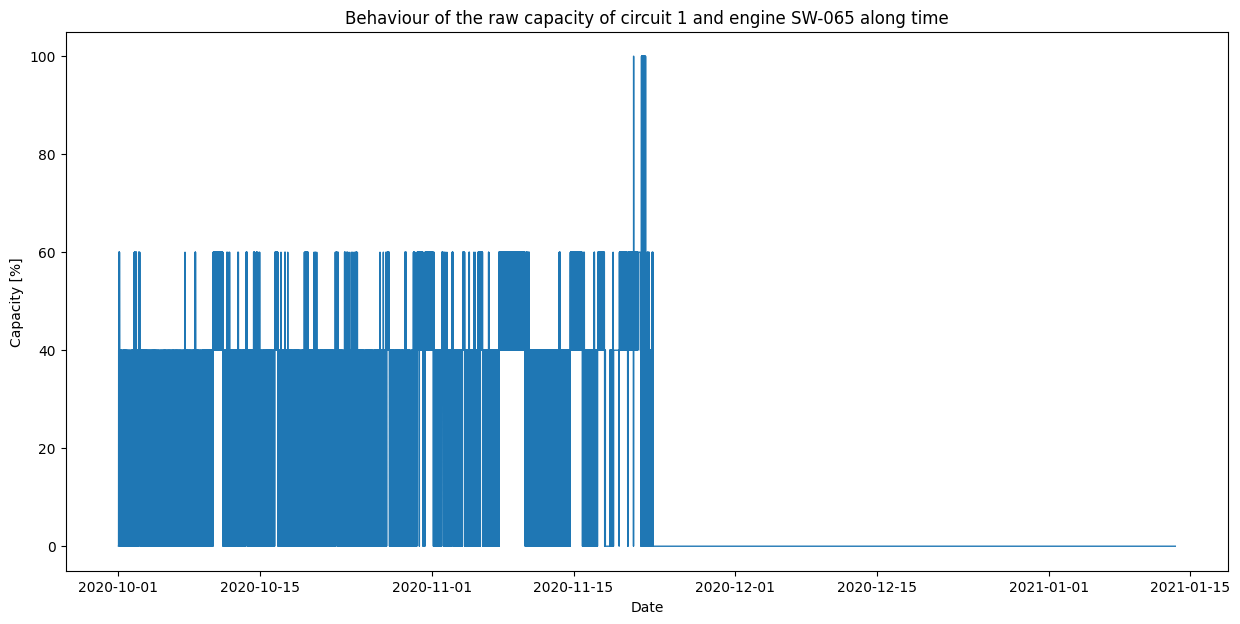

In [9]:
# Select the metric S125 which correspond to the capacity of circuit 1
load_percentage_C1_e1 = df_sw065[df_sw065.metric == "S125"].toPandas()
load_percentage_C1_e1["Date"] = pd.to_datetime(load_percentage_C1_e1["when"])

# Plot the raw loading percentage of circuit 1
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(load_percentage_C1_e1["Date"], load_percentage_C1_e1["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 1 and engine SW-065 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [10]:
# Available values of loading percentage in circuit 1
load_percentage_C1_e1 = df_sw065[df_sw065.metric == "S125"]
load_percentage_C1_e1.select(F.col('value')).distinct().collect()

[Row(value=40), Row(value=60), Row(value=0), Row(value=100)]

Text(0, 0.5, 'Capacity [%]')

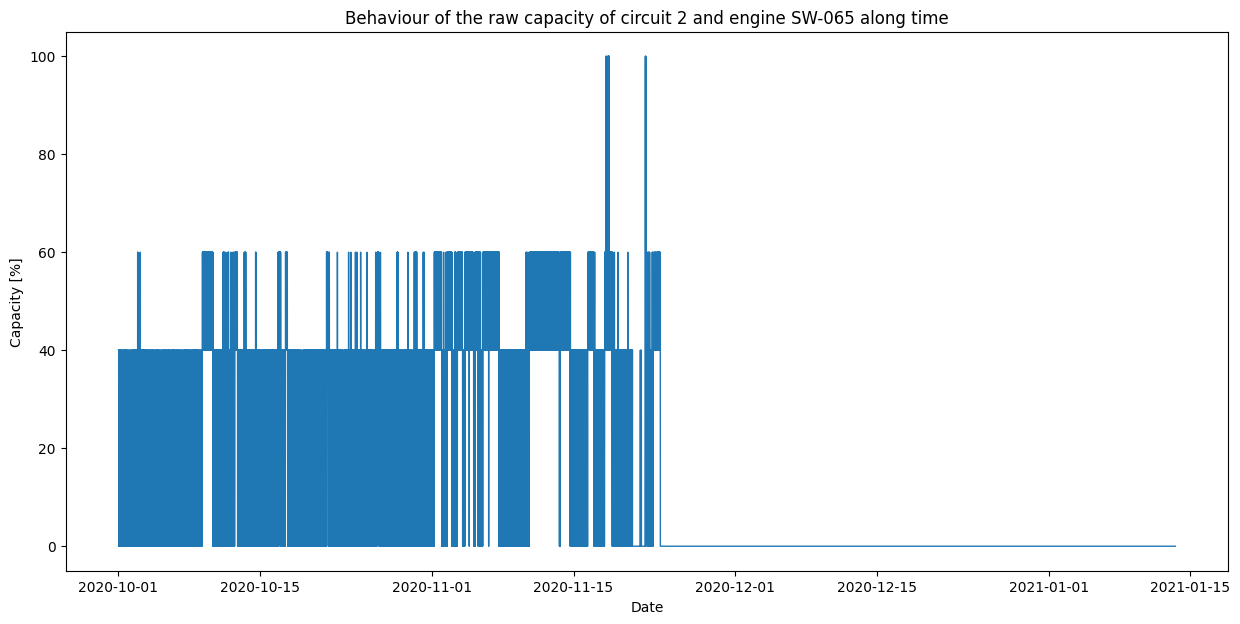

In [11]:
# Select the metric S181 which correspond to the capacity of circuit 2
load_percentage_C2_e1 = df_sw065[df_sw065.metric == "S181"].toPandas()
load_percentage_C2_e1["Date"] = pd.to_datetime(load_percentage_C2_e1["when"])

# Plot the raw loading percentage of circuit 2
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(load_percentage_C2_e1["Date"], load_percentage_C2_e1["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 2 and engine SW-065 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [12]:
# Available values of loading percentage in circuit 2
load_percentage_C2_e1 = df_sw065[df_sw065.metric == "S181"]
load_percentage_C2_e1.select(F.col('value')).distinct().collect()

[Row(value=40), Row(value=60), Row(value=0), Row(value=100)]

Text(0, 0.5, 'External temperature [°C]')

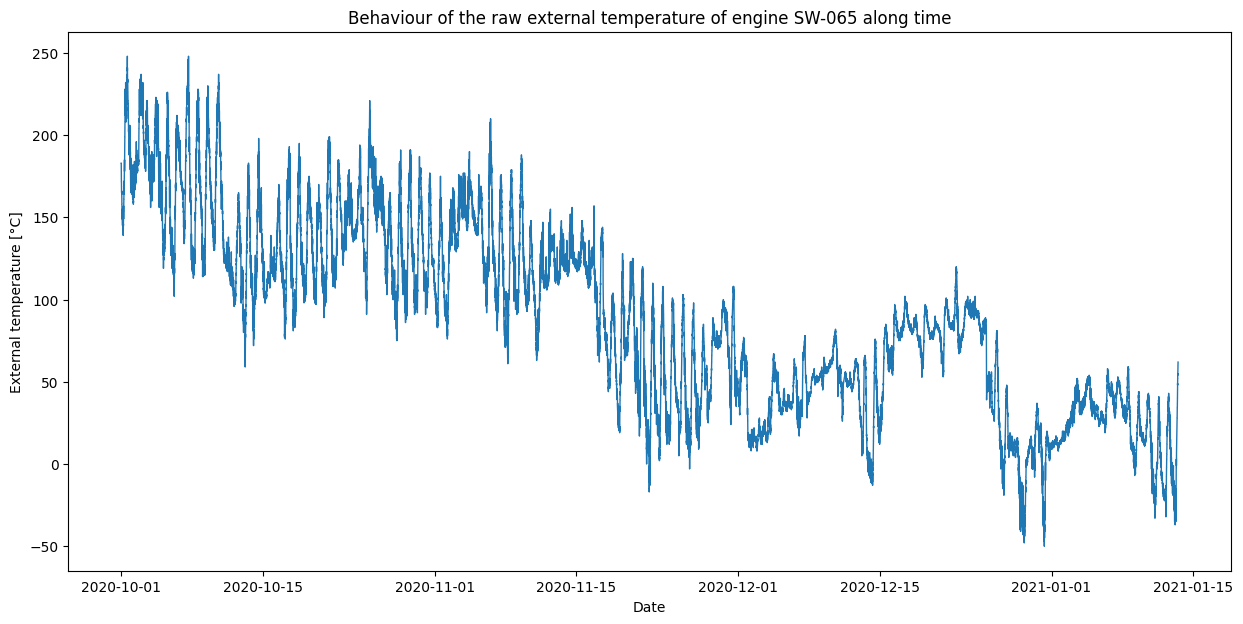

In [13]:
# Select the metric S41 which corresponds to the external temperature in °C
external_temperature_e1 = df_sw065[df_sw065.metric == "S41"].toPandas()
external_temperature_e1["Date"] = pd.to_datetime(external_temperature_e1["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_e1["Date"], external_temperature_e1["value"], linewidth=1)
ax.set_title("Behaviour of the raw external temperature of engine SW-065 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

**Remove Noise**

Before to proceed with the corresponding analysis is necessary to work on the external temperature in order to remove some noise that could exist. For this we apply moving average procedure for removing irregular sensor readings, and reaching smooth average data values.

Text(0, 0.5, 'External temperature [°C]')

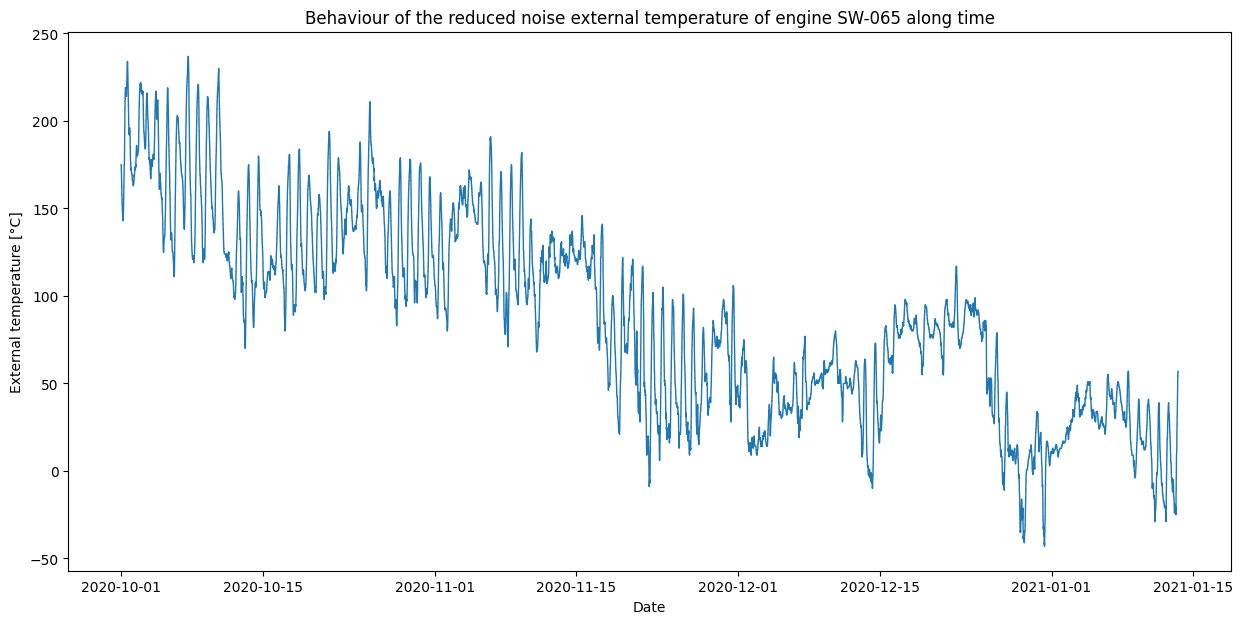

In [14]:
# Avoid the noise

window =  Window.partitionBy("metric").orderBy("when").rowsBetween(-50, 50)

xternal_temperature_e1 = df_sw065[df_sw065.metric == "S41"]
external_temperature_without_noise_e1 = xternal_temperature_e1.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when").toPandas()
external_temperature_without_noise_e1["Date"] = pd.to_datetime(external_temperature_without_noise_e1["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_without_noise_e1['Date'], external_temperature_without_noise_e1['value_without_noise'], linewidth=1)
ax.set_title("Behaviour of the reduced noise external temperature of engine SW-065 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

**Normalization**

The last step before to perform the correlation analysis between the external temperature and the loading percentage of the circuits is the normalization of the columns. For this, we are going to normalize for each hour.

In [15]:
# loading percentage of the devices, Circ 1, normalized per HOUR

percentage_C1_e1_hour = load_percentage_C1_e1.withColumn("when_hour", F.date_trunc("hour", F.col("when")))

normalized_percent_C1_e1_mean = percentage_C1_e1_hour.groupby('when_hour').agg(F.ceil(F.mean('value')).alias('value_new')).sort('when_hour')
normalized_percent_C1_e1_max = percentage_C1_e1_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')
normalized_percent_C1_e1_min = percentage_C1_e1_hour.groupby('when_hour').agg(F.min('value').alias('value_new')).sort('when_hour')
#normalized_percent_C1_mode = percentage_C1.groupby('when_hour').agg(compute_mode(percentage_C1, "value").alias('value_new')).sort('when_hour')

In [16]:
# loading percentage of the devices, Circ 2, normalized per HOUR

percentage_C2_e1_hour = load_percentage_C2_e1.withColumn("when_hour", F.date_trunc("hour", F.col("when")))

normalized_percent_C2_e1_mean = percentage_C2_e1_hour.groupby('when_hour').agg(F.ceil(F.mean('value')).alias('value_new')).sort('when_hour')
normalized_percent_C2_e1_max = percentage_C2_e1_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')
normalized_percent_C2_e1_min = percentage_C2_e1_hour.groupby('when_hour').agg(F.min('value').alias('value_new')).sort('when_hour')
#normalized_percent_C1_mode = percentage_C1.groupby('when_hour').agg(compute_mode(percentage_C1, "value").alias('value_new')).sort('when_hour')

In [17]:
# external temperature normalized per HOUR
external_temperature_without_noise_e1 = xternal_temperature_e1.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when")

external_temperature_e1_hour = external_temperature_without_noise_e1.withColumn("when_hour", F.date_trunc("hour", F.col("when")))

normalized_exTemp_e1_mean = external_temperature_e1_hour.groupby('when_hour').agg(F.ceil(F.mean('value_without_noise')).alias('value_new')).sort('when_hour')
normalized_exTemp_e1_max = external_temperature_e1_hour.groupby('when_hour').agg(F.max('value_without_noise').alias('value_new')).sort('when_hour')
normalized_exTemp_e1_min = external_temperature_e1_hour.groupby('when_hour').agg(F.min('value_without_noise').alias('value_new')).sort('when_hour')

**Analysis of the correlations**

***CIRCUIT 1***

In [18]:
# make sure no missing values

normalized_percent_C1_e1_max.join(normalized_exTemp_e1_mean, normalized_percent_C1_e1_max.when_hour == normalized_exTemp_e1_mean.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



Text(0.5, 0, 'Loading percentage [%]')

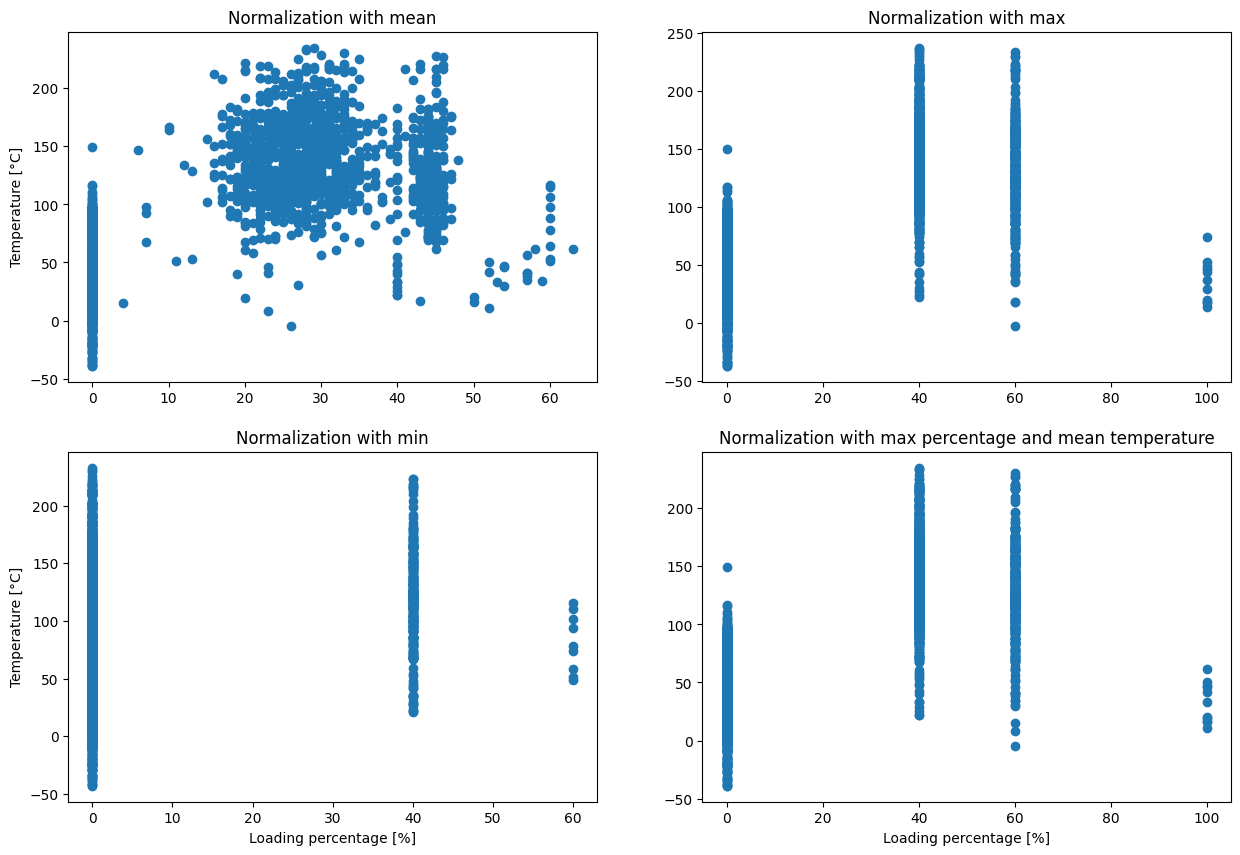

In [19]:
#scatter per HOUR between the external temperature and the loading percentage of CIRCUIT 1

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

ax[0][0].scatter(normalized_percent_C1_e1_mean.select(F.col('value_new')).toPandas(), normalized_exTemp_e1_mean.select(F.col('value_new')).toPandas())
ax[0][0].set_title("Normalization with mean")
ax[0][0].set_ylabel("Temperature [°C]")
ax[0][1].scatter(normalized_percent_C1_e1_max.select(F.col('value_new')).toPandas(), normalized_exTemp_e1_max.select(F.col('value_new')).toPandas())
ax[0][1].set_title("Normalization with max")
ax[1][0].scatter(normalized_percent_C1_e1_min.select(F.col('value_new')).toPandas(), normalized_exTemp_e1_min.select(F.col('value_new')).toPandas())
ax[1][0].set_title("Normalization with min")
ax[1][0].set_xlabel("Loading percentage [%]")
ax[1][0].set_ylabel("Temperature [°C]")
ax[1][1].scatter(normalized_percent_C1_e1_max.select(F.col('value_new')).toPandas(), normalized_exTemp_e1_mean.select(F.col('value_new')).toPandas())
ax[1][1].set_title("Normalization with max percentage and mean temperature")
ax[1][1].set_xlabel("Loading percentage [%]")

Text(0, 0.5, 'Temperature [°C]')

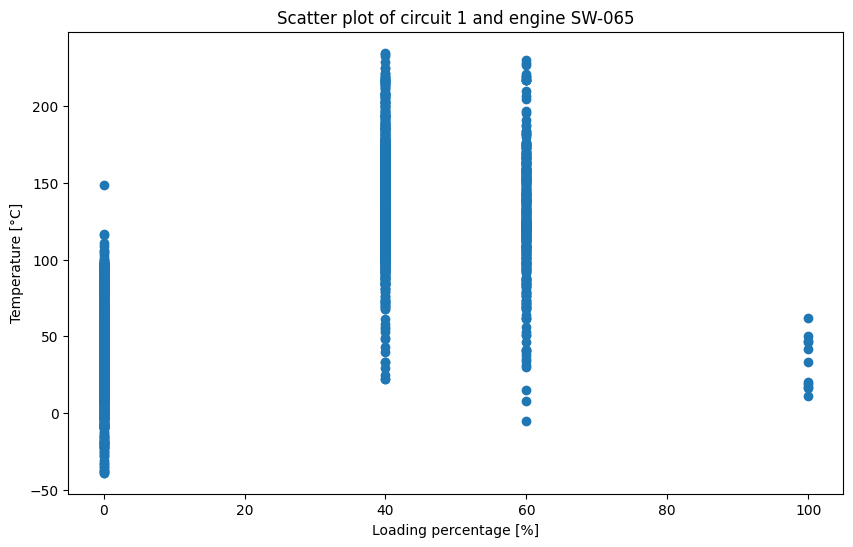

In [20]:
#scatter per HOUR between the external temperature and the loading percentage of CIRCUIT 1

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(normalized_percent_C1_e1_max.select(F.col('value_new')).toPandas(), normalized_exTemp_e1_mean.select(F.col('value_new')).toPandas())
ax.set_title("Scatter plot of circuit 1 and engine SW-065")
ax.set_xlabel("Loading percentage [%]")
ax.set_ylabel("Temperature [°C]")

***CIRCUIT 2***

In [21]:
# make sure no missing values

normalized_percent_C2_e1_max.join(normalized_exTemp_e1_mean, normalized_percent_C2_e1_max.when_hour == normalized_exTemp_e1_mean.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



Text(0, 0.5, 'Temperature [°C]')

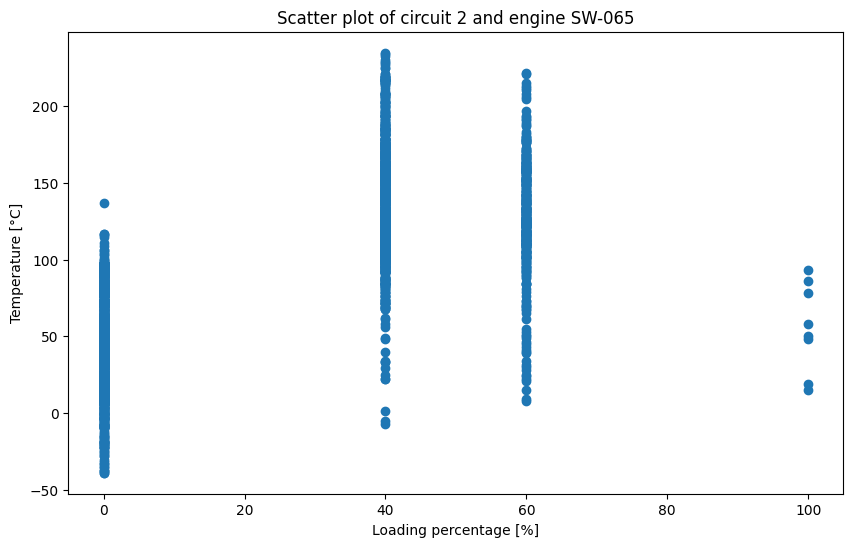

In [22]:
#scatter per HOUR between the external temperature and the loading percentage of CIRCUIT 2

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(normalized_percent_C2_e1_max.select(F.col('value_new')).toPandas(), normalized_exTemp_e1_mean.select(F.col('value_new')).toPandas())
ax.set_title("Scatter plot of circuit 2 and engine SW-065")
ax.set_xlabel("Loading percentage [%]")
ax.set_ylabel("Temperature [°C]")

***SUMMARY***

<Axes: >

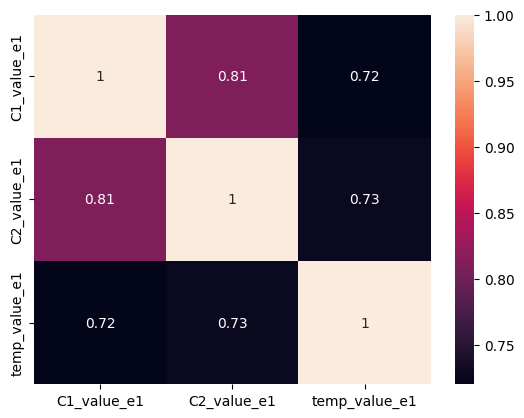

In [23]:
# Heat correlation map

corr_df_e1 = normalized_percent_C1_e1_max.withColumnRenamed("value_new", "C1_value_e1").join(normalized_percent_C2_e1_max.withColumnRenamed("value_new", "C2_value_e1"), normalized_percent_C1_e1_max.when_hour == normalized_percent_C2_e1_max.when_hour, "inner")
corr_df_e1 = corr_df_e1.join(normalized_exTemp_e1_mean.withColumnRenamed("value_new", "temp_value_e1"), normalized_percent_C1_e1_max.when_hour == normalized_exTemp_e1_mean.when_hour, "inner")

corr_e1 = corr_df_e1.select("C1_value_e1", "C2_value_e1", "temp_value_e1").toPandas().corr()

sns.heatmap(corr_e1, annot=True)

Text(0.5, 0, 'Loading percentage [%]')

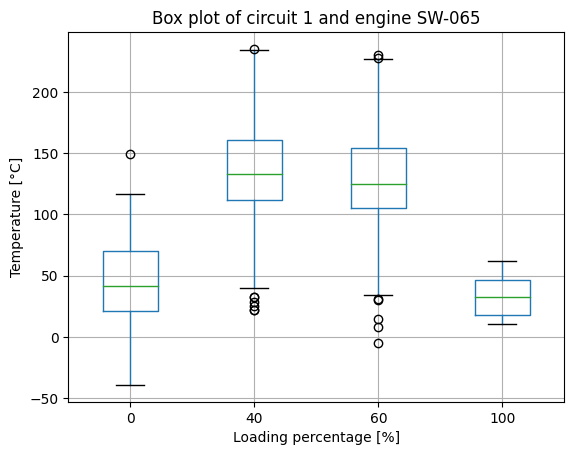

In [24]:
temp_0p_C1_e1 = corr_df_e1[corr_df_e1.C1_value_e1 == 0].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]
temp_40p_C1_e1 = corr_df_e1[corr_df_e1.C1_value_e1 == 40].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]
temp_60p_C1_e1 = corr_df_e1[corr_df_e1.C1_value_e1 == 60].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]
temp_100p_C1_e1 = corr_df_e1[corr_df_e1.C1_value_e1 == 100].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]

temp_C1_e1 = pd.DataFrame({
    "0" : temp_0p_C1_e1,
    "40" : temp_40p_C1_e1,
    "60" : temp_60p_C1_e1,
    "100" : temp_100p_C1_e1
})

boxplot = temp_C1_e1.boxplot(column=['0', '40', '60', '100'])
plt.title("Box plot of circuit 1 and engine SW-065")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

Text(0.5, 0, 'Loading percentage [%]')

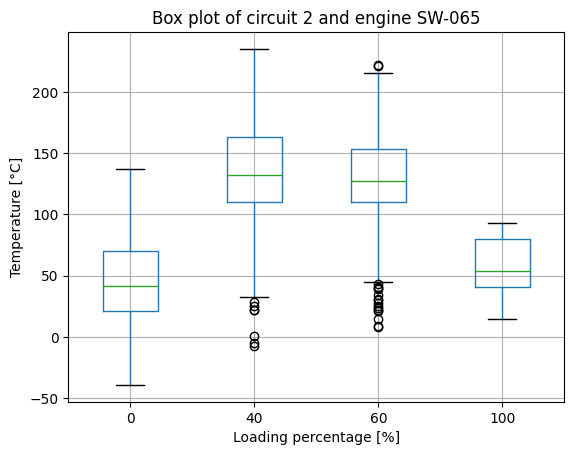

In [25]:
temp_0p_C2_e1 = corr_df_e1[corr_df_e1.C2_value_e1 == 0].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]
temp_40p_C2_e1 = corr_df_e1[corr_df_e1.C2_value_e1 == 40].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]
temp_60p_C2_e1 = corr_df_e1[corr_df_e1.C2_value_e1 == 60].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]
temp_100p_C2_e1 = corr_df_e1[corr_df_e1.C2_value_e1 == 100].select(F.col("temp_value_e1")).toPandas()["temp_value_e1"]

temp_C1_e1 = pd.DataFrame({
    "0" : temp_0p_C2_e1,
    "40" : temp_40p_C2_e1,
    "60" : temp_60p_C2_e1,
    "100" : temp_100p_C2_e1
})

boxplot = temp_C1_e1.boxplot(column=['0', '40', '60', '100'])
plt.title("Box plot of circuit 2 and engine SW-065")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

## Engine SW-088

Text(0, 0.5, 'Capacity [%]')

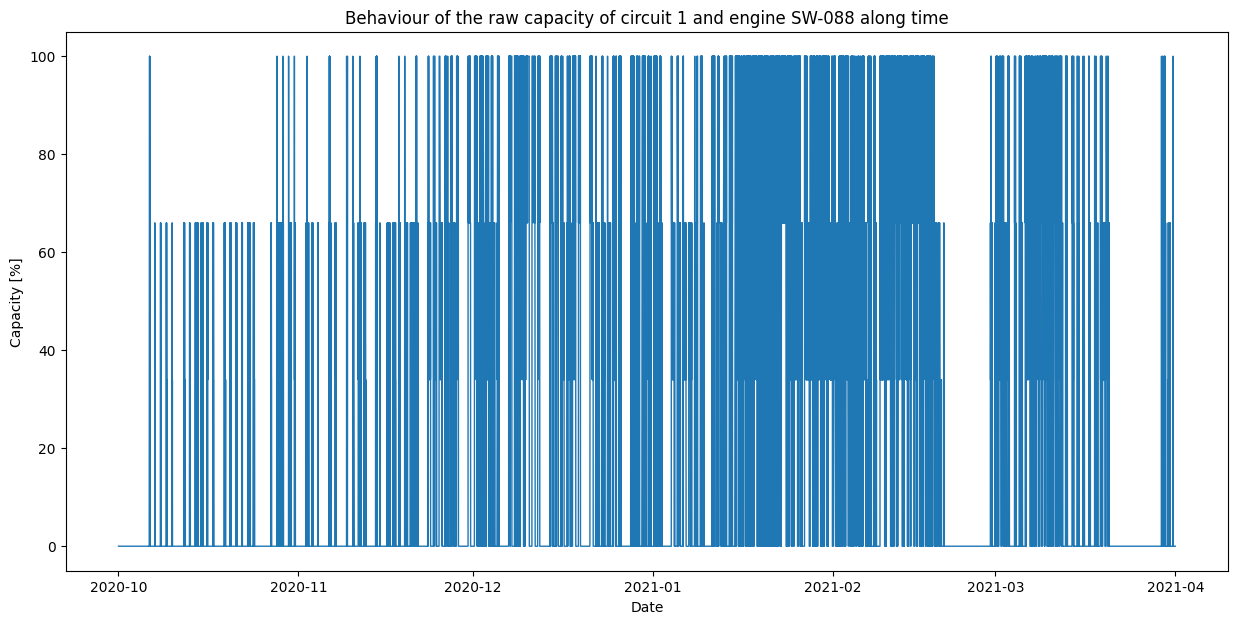

In [10]:
# Select the metric S125 which correspond to the capacity of circuit 1
load_percentage_C1_e2 = df_sw088[df_sw088.metric == "S125"].toPandas()
load_percentage_C1_e2["Date"] = pd.to_datetime(load_percentage_C1_e2["when"])

# Plot the raw loading percentage of circuit 1
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(load_percentage_C1_e2["Date"], load_percentage_C1_e2["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 1 and engine SW-088 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [11]:
# Available values of loading percentage in circuit 1
load_percentage_C1_e2 = df_sw088[df_sw088.metric == "S125"]
load_percentage_C1_e2.select(F.col('value')).distinct().collect()

[Row(value=34), Row(value=100), Row(value=66), Row(value=0)]

Text(0, 0.5, 'Capacity [%]')

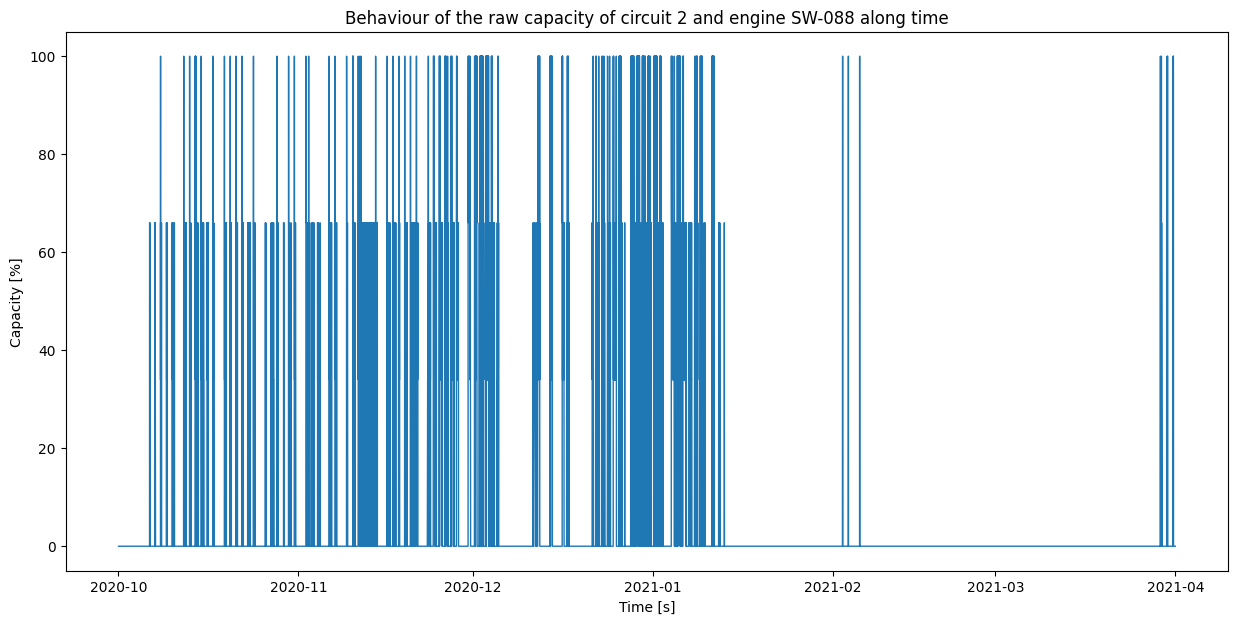

In [14]:
load_percentage_C2_e2 = df_sw088[df_sw088.metric == "S181"].toPandas()
load_percentage_C2_e2["Date"] = pd.to_datetime(load_percentage_C2_e2["when"])

# Plot the raw loading percentage of circuit 1
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(load_percentage_C2_e2["Date"], load_percentage_C2_e2["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 2 and engine SW-088 along time")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Capacity [%]")

In [15]:
# Available values of loading percentage in circuit 2
load_percentage_C2_e2 = df_sw088[df_sw088.metric == "S181"]
load_percentage_C2_e2.select(F.col('value')).distinct().collect()

[Row(value=34), Row(value=100), Row(value=66), Row(value=0)]

Text(0, 0.5, 'External temperature [°C]')

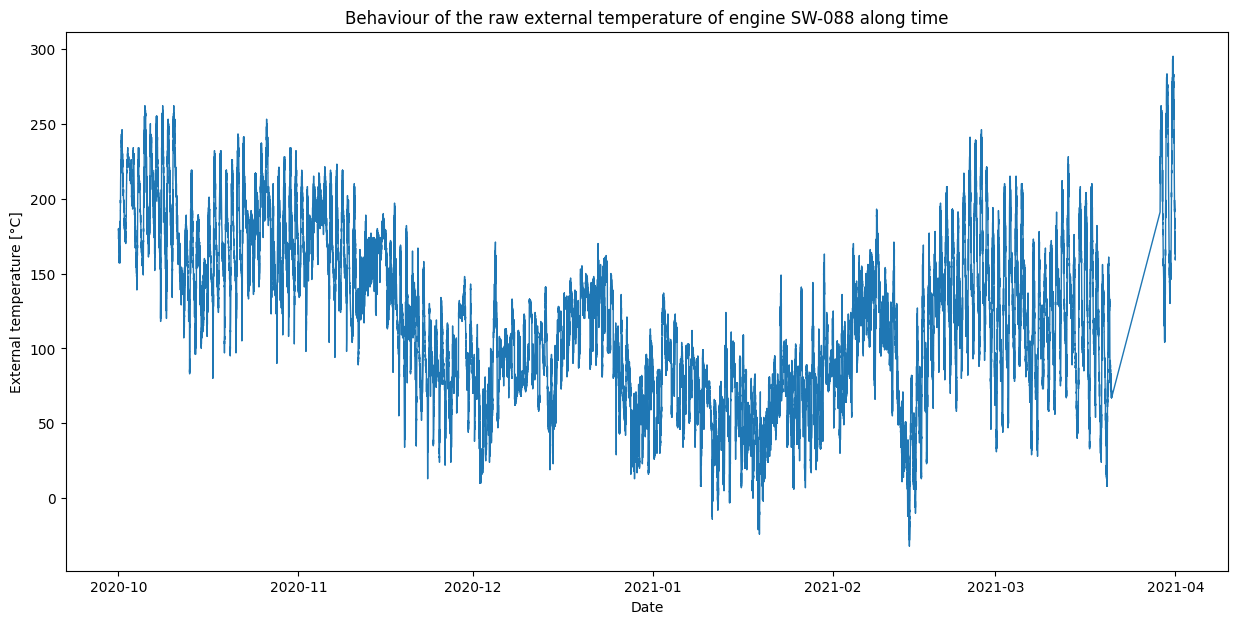

In [16]:
# Select the metric S41 which corresponds to the external temperature in °C
external_temperature_e2 = df_sw088[df_sw088.metric == "S41"].toPandas()
external_temperature_e2["Date"] = pd.to_datetime(external_temperature_e2["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_e2["Date"], external_temperature_e2["value"], linewidth=1)
ax.set_title("Behaviour of the raw external temperature of engine SW-088 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

Text(0, 0.5, 'External temperature [°C]')

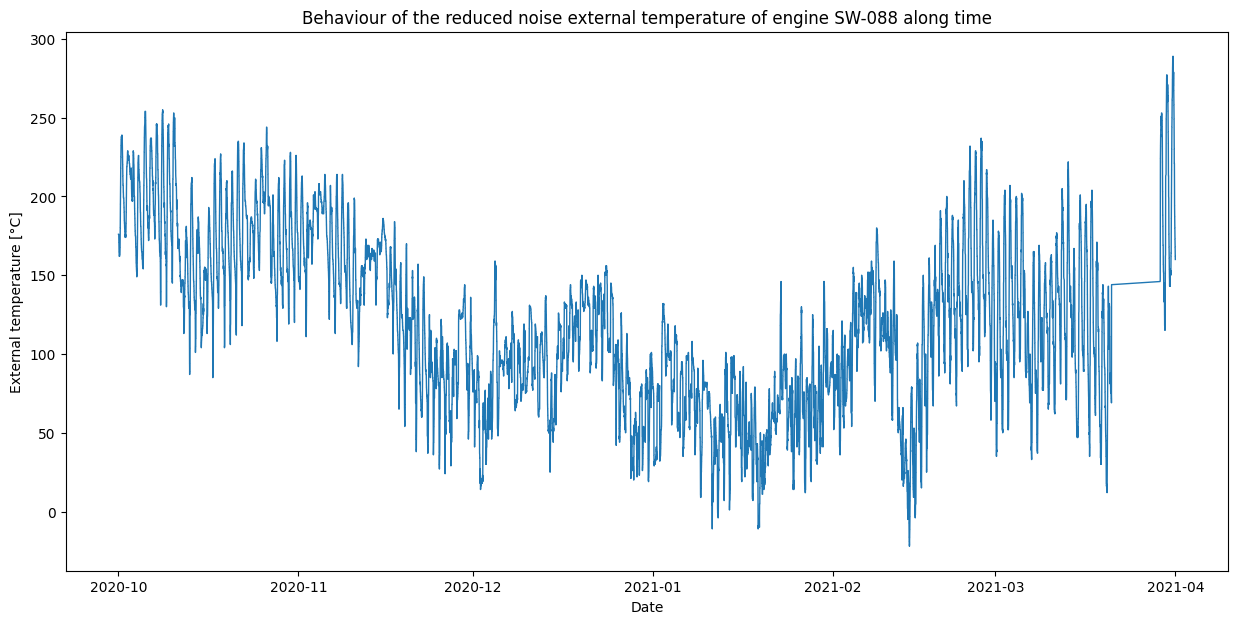

In [17]:
# Remove the noise of the external temperature

window =  Window.partitionBy("metric").orderBy("when").rowsBetween(-50, 50)

xternal_temperature_e2 = df_sw088[df_sw088.metric == "S41"]
external_temperature_without_noise_e2 = xternal_temperature_e2.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when").toPandas()
external_temperature_without_noise_e2["Date"] = pd.to_datetime(external_temperature_without_noise_e2["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_without_noise_e2['Date'], external_temperature_without_noise_e2['value_without_noise'], linewidth=1)
ax.set_title("Behaviour of the reduced noise external temperature of engine SW-088 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

**Normalization**

Now we are going to normalize the data, but using the knowledge obtained when we work with the engine SW-065. Then, one more time we normalize for every HOUR, but when we work on the loading percentage the used feature is the maximum, and when we work on the external temperature the used feature is the mean.

In [18]:
# loading percentage of the devices, Circ 1, normalized per HOUR with the feature MAX
percentage_C1_e2_hour = load_percentage_C1_e2.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_percent_C1_e2_max = percentage_C1_e2_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')

# loading percentage of the devices, Circ 2, normalized per HOUR with the feature MAX
percentage_C2_e2_hour = load_percentage_C2_e2.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_percent_C2_e2_max = percentage_C2_e2_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')

# external temperature normalized per HOUR with the feature MEAN
xternal_temperature_e2 = df_sw088[df_sw088.metric == "S41"]
external_temperature_without_noise_e2 = xternal_temperature_e2.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when")
external_temperature_e2_hour = external_temperature_without_noise_e2.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_exTemp_e2_mean = external_temperature_e2_hour.groupby('when_hour').agg(F.ceil(F.mean('value_without_noise')).alias('value_new')).sort('when_hour')

**Analysis of correlations**

In [19]:
## CIRCUIT 1

# make sure no missing values
normalized_exTemp_e2_mean.join(normalized_percent_C1_e2_max, normalized_exTemp_e2_mean.when_hour == normalized_percent_C1_e2_max.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



In [20]:
## CIRCUIT 2

# make sure no missing values 1
extra_normalized_exTemp_e2_mean = normalized_exTemp_e2_mean.join(normalized_percent_C2_e2_max, normalized_exTemp_e2_mean.when_hour == normalized_percent_C2_e2_max.when_hour, how = "leftanti")
extra_normalized_exTemp_e2_mean.show()
normalized_exTemp_e2_mean = normalized_exTemp_e2_mean.join(extra_normalized_exTemp_e2_mean, normalized_exTemp_e2_mean.when_hour == extra_normalized_exTemp_e2_mean.when_hour, "leftanti")

# make sure no missing values 2
extra_normalized_percent_C2_e2_max = normalized_percent_C2_e2_max.join(normalized_exTemp_e2_mean, normalized_percent_C2_e2_max.when_hour == normalized_exTemp_e2_mean.when_hour, how = "leftanti")
extra_normalized_percent_C2_e2_max.show()
normalized_percent_C2_e2_max = normalized_percent_C2_e2_max.join(extra_normalized_percent_C2_e2_max, normalized_percent_C2_e2_max.when_hour == extra_normalized_percent_C2_e2_max.when_hour, how = "leftanti")

+-------------------+---------+
|          when_hour|value_new|
+-------------------+---------+
|2020-11-10 07:00:00|      114|
|2021-02-01 05:00:00|       54|
|2021-03-10 14:00:00|      160|
+-------------------+---------+



+-------------------+---------+
|          when_hour|value_new|
+-------------------+---------+
|2020-11-24 09:00:00|       66|
+-------------------+---------+



***SUMMARY***

<Axes: >

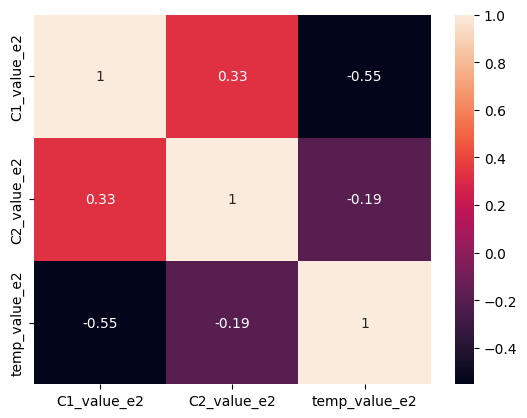

In [22]:
# Heat correlation map
corr_df_C1T_e2 = normalized_percent_C1_e2_max.withColumnRenamed("value_new", "C1_value_e2").join(normalized_exTemp_e2_mean.withColumnRenamed("value_new", "temp_value_e2"), normalized_percent_C1_e2_max.when_hour == normalized_exTemp_e2_mean.when_hour, "inner")
#corr_df_C2T_e2 = normalized_percent_C2_e2_max.withColumnRenamed("value_new", "C2_value_e2").join(normalized_exTemp_e2_mean.withColumnRenamed("value_new", "temp_value_e2"), normalized_percent_C2_e2_max.when_hour == normalized_exTemp_e2_mean.when_hour, "inner")

corr_df_e2 = corr_df_C1T_e2.join(normalized_percent_C2_e2_max.withColumnRenamed("value_new", "C2_value_e2"), normalized_percent_C1_e2_max.when_hour == normalized_percent_C2_e2_max.when_hour, "inner")

corr_e2 = corr_df_e2.select("C1_value_e2", "C2_value_e2", "temp_value_e2").toPandas().corr()

sns.heatmap(corr_e2, annot=True)

Text(0.5, 0, 'Loading percentage [%]')

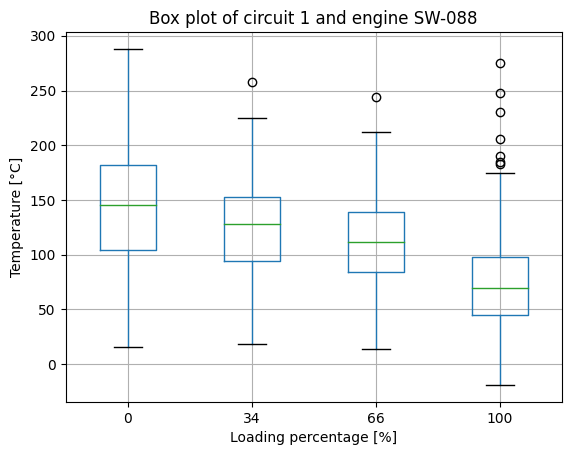

In [23]:
temp_0p_C1_e2 = corr_df_e2[corr_df_e2.C1_value_e2 == 0].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]
temp_34p_C1_e2 = corr_df_e2[corr_df_e2.C1_value_e2 == 34].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]
temp_66p_C1_e2 = corr_df_e2[corr_df_e2.C1_value_e2 == 66].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]
temp_100p_C1_e2 = corr_df_e2[corr_df_e2.C1_value_e2 == 100].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]

temp_C1_e2 = pd.DataFrame({
    "0" : temp_0p_C1_e2,
    "34" : temp_34p_C1_e2,
    "66" : temp_66p_C1_e2,
    "100" : temp_100p_C1_e2
})

boxplot = temp_C1_e2.boxplot(column=['0', '34', '66', '100'])
plt.title("Box plot of circuit 1 and engine SW-088")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

Text(0.5, 0, 'Loading percentage [%]')

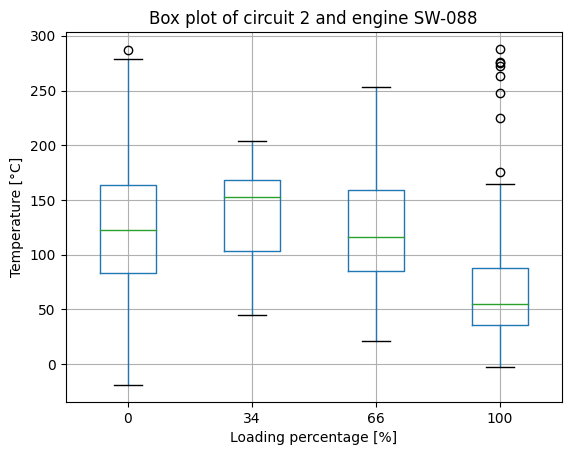

In [24]:
temp_0p_C2_e2 = corr_df_e2[corr_df_e2.C2_value_e2 == 0].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]
temp_34p_C2_e2 = corr_df_e2[corr_df_e2.C2_value_e2 == 34].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]
temp_66p_C2_e2 = corr_df_e2[corr_df_e2.C2_value_e2 == 66].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]
temp_100p_C2_e2 = corr_df_e2[corr_df_e2.C2_value_e2 == 100].select(F.col("temp_value_e2")).toPandas()["temp_value_e2"]

temp_C2_e2 = pd.DataFrame({
    "0" : temp_0p_C2_e2,
    "34" : temp_34p_C2_e2,
    "66" : temp_66p_C2_e2,
    "100" : temp_100p_C2_e2
})

boxplot = temp_C2_e2.boxplot(column=['0', '34', '66', '100'])
plt.title("Box plot of circuit 2 and engine SW-088")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

## Engine SW-106

Text(0, 0.5, 'Capacity [%]')

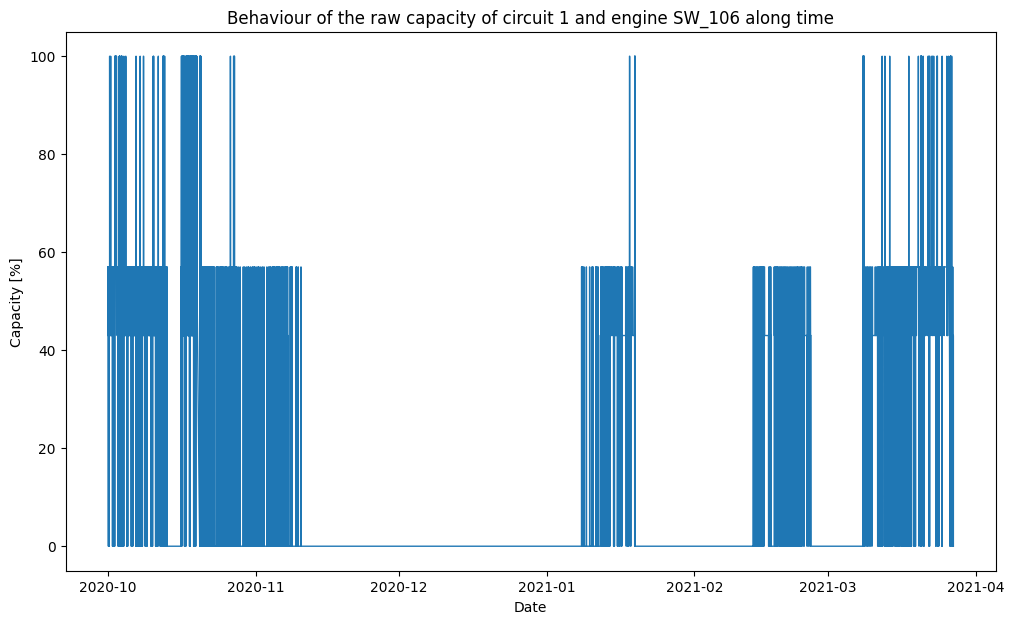

In [25]:
load_percentage_C1_e3 = df_sw106[df_sw106.metric == "S125"].toPandas()
load_percentage_C1_e3["Date"] = pd.to_datetime(load_percentage_C1_e3["when"])

# Plot the raw loading percentage of circuit 1
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(load_percentage_C1_e3["Date"], load_percentage_C1_e3["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 1 and engine SW_106 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [9]:
# Available values of loading percentage in circuit 1
load_percentage_C1_e3 = df_sw106[df_sw106.metric == "S125"]
load_percentage_C1_e3.select(F.col('value')).distinct().collect()

[Row(value=57), Row(value=43), Row(value=100), Row(value=0)]

Text(0, 0.5, 'Capacity [%]')

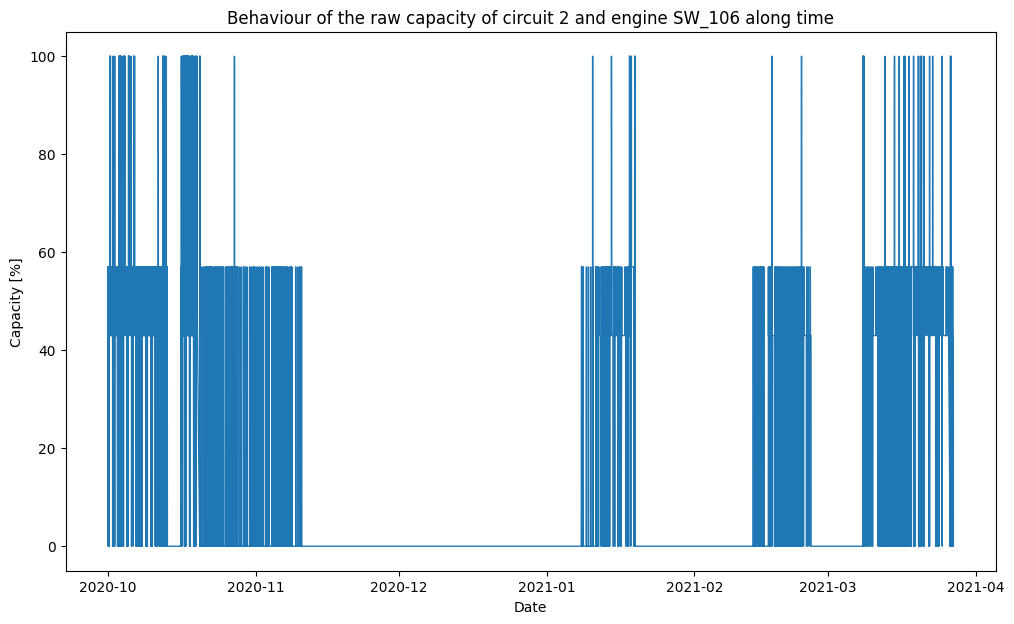

In [27]:
load_percentage_C2_e3 = df_sw106[df_sw106.metric == "S181"].toPandas()
load_percentage_C2_e3["Date"] = pd.to_datetime(load_percentage_C2_e3["when"])

# Plot the raw loading percentage of circuit 2
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(load_percentage_C2_e3["Date"], load_percentage_C2_e3["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 2 and engine SW_106 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [10]:
# Available values of loading percentage in circuit 2
load_percentage_C2_e3 = df_sw106[df_sw106.metric == "S181"]
load_percentage_C2_e3.select(F.col('value')).distinct().collect()

[Row(value=57), Row(value=43), Row(value=100), Row(value=0)]

Text(0, 0.5, 'External temperature [°C]')

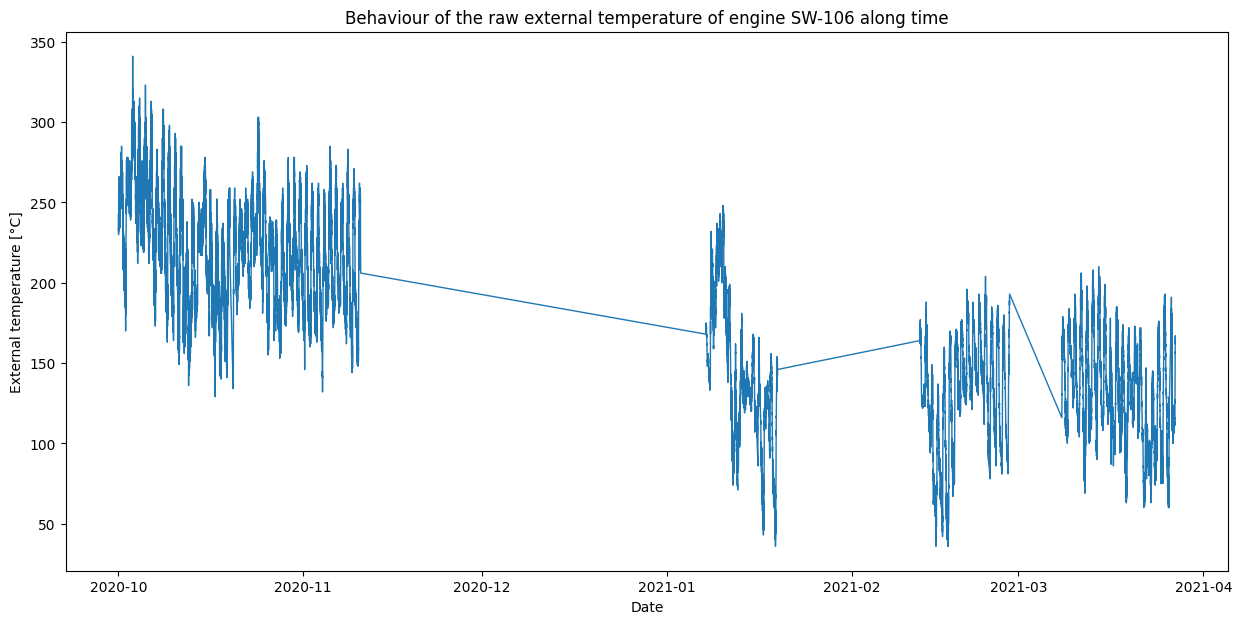

In [29]:
# Select the metric S41 which corresponds to the external temperature in °C
external_temperature_e3 = df_sw106[df_sw106.metric == "S41"].toPandas()
external_temperature_e3["Date"] = pd.to_datetime(external_temperature_e3["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_e3["Date"], external_temperature_e3["value"], linewidth=1)
ax.set_title("Behaviour of the raw external temperature of engine SW-106 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

Text(0, 0.5, 'External temperature [°C]')

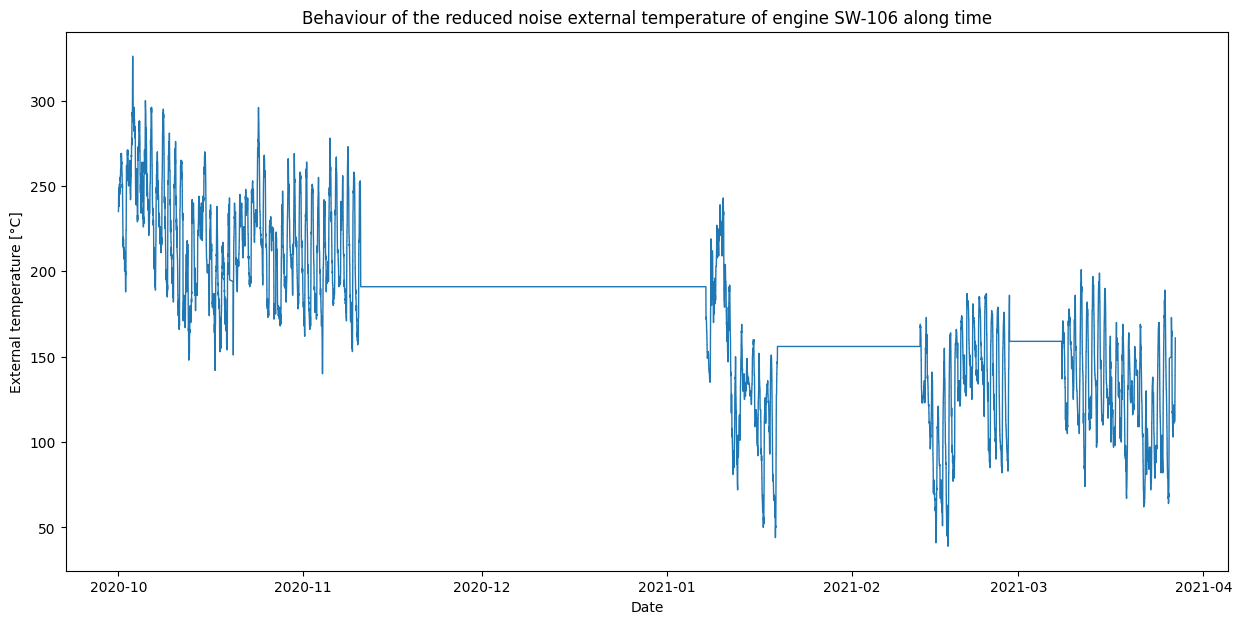

In [12]:
# Remove the noise of the external temperature

window =  Window.partitionBy("metric").orderBy("when").rowsBetween(-50, 50)

xternal_temperature_e3 = df_sw106[df_sw106.metric == "S41"]
external_temperature_without_noise_e3 = xternal_temperature_e3.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when").toPandas()
external_temperature_without_noise_e3["Date"] = pd.to_datetime(external_temperature_without_noise_e3["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_without_noise_e3['Date'], external_temperature_without_noise_e3['value_without_noise'], linewidth=1)
ax.set_title("Behaviour of the reduced noise external temperature of engine SW-106 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

In [15]:
## NORMALIZATION

# loading percentage of the devices, Circ 1, normalized per HOUR with the feature MAX
percentage_C1_e3_hour = load_percentage_C1_e3.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_percent_C1_e3_max = percentage_C1_e3_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')

# loading percentage of the devices, Circ 2, normalized per HOUR with the feature MAX
percentage_C2_e3_hour = load_percentage_C2_e3.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_percent_C2_e3_max = percentage_C2_e3_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')

# external temperature normalized per HOUR with the feature MEAN
xternal_temperature_e3 = df_sw106[df_sw106.metric == "S41"]
external_temperature_without_noise_e3 = xternal_temperature_e3.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when")
external_temperature_e3_hour = external_temperature_without_noise_e3.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_exTemp_e3_mean = external_temperature_e3_hour.groupby('when_hour').agg(F.ceil(F.mean('value_without_noise')).alias('value_new')).sort('when_hour')

**Analysis of correlations**

In [16]:
## CIRCUIT 1

# make sure no missing values
normalized_percent_C1_e3_max.join(normalized_exTemp_e3_mean, normalized_percent_C1_e3_max.when_hour == normalized_exTemp_e3_mean.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



In [17]:
## CIRCUIT 2

# make sure no missing values 2
normalized_percent_C2_e3_max.join(normalized_exTemp_e3_mean, normalized_percent_C2_e3_max.when_hour == normalized_exTemp_e3_mean.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



***SUMMARY***

<Axes: >

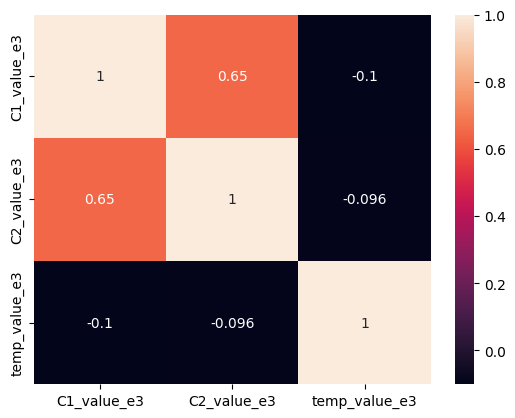

In [18]:
# Heat map of correlations
corr_df_C1T_e3 = normalized_percent_C1_e3_max.withColumnRenamed("value_new", "C1_value_e3").join(normalized_exTemp_e3_mean.withColumnRenamed("value_new", "temp_value_e3"), normalized_percent_C1_e3_max.when_hour == normalized_exTemp_e3_mean.when_hour, "inner")
corr_df_e3 = corr_df_C1T_e3.join(normalized_percent_C2_e3_max.withColumnRenamed("value_new", "C2_value_e3"), normalized_percent_C1_e3_max.when_hour == normalized_percent_C2_e3_max.when_hour, "inner")

corr_e3 = corr_df_e3.select("C1_value_e3", "C2_value_e3", "temp_value_e3").toPandas().corr()

sns.heatmap(corr_e3, annot=True)

Text(0.5, 0, 'Loading percentage [%]')

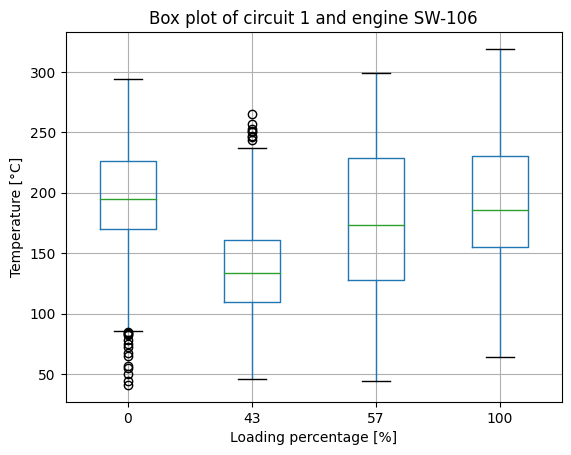

In [19]:
temp_0p_C1_e3 = corr_df_e3[corr_df_e3.C1_value_e3 == 0].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]
temp_43p_C1_e3 = corr_df_e3[corr_df_e3.C1_value_e3 == 43].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]
temp_57p_C1_e3 = corr_df_e3[corr_df_e3.C1_value_e3 == 57].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]
temp_100p_C1_e3 = corr_df_e3[corr_df_e3.C1_value_e3 == 100].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]

temp_C1_e3 = pd.DataFrame({
    "0" : temp_0p_C1_e3,
    "43" : temp_43p_C1_e3,
    "57" : temp_57p_C1_e3,
    "100" : temp_100p_C1_e3
})

boxplot = temp_C1_e3.boxplot(column=['0', '43', '57', '100'])
plt.title("Box plot of circuit 1 and engine SW-106")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

Text(0.5, 0, 'Loading percentage [%]')

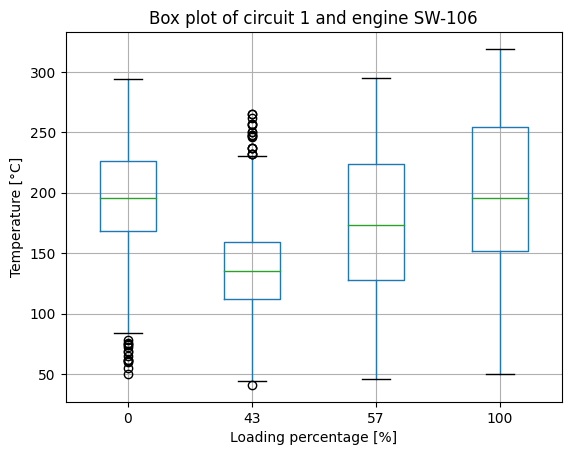

In [20]:
temp_0p_C2_e3 = corr_df_e3[corr_df_e3.C2_value_e3 == 0].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]
temp_43p_C2_e3 = corr_df_e3[corr_df_e3.C2_value_e3 == 43].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]
temp_57p_C2_e3 = corr_df_e3[corr_df_e3.C2_value_e3 == 57].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]
temp_100p_C2_e3 = corr_df_e3[corr_df_e3.C2_value_e3 == 100].select(F.col("temp_value_e3")).toPandas()["temp_value_e3"]

temp_C2_e3 = pd.DataFrame({
    "0" : temp_0p_C2_e3,
    "43" : temp_43p_C2_e3,
    "57" : temp_57p_C2_e3,
    "100" : temp_100p_C2_e3
})

boxplot = temp_C2_e3.boxplot(column=['0', '43', '57', '100'])
plt.title("Box plot of circuit 1 and engine SW-106")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

## SW-115

Text(0, 0.5, 'Capacity [%]')

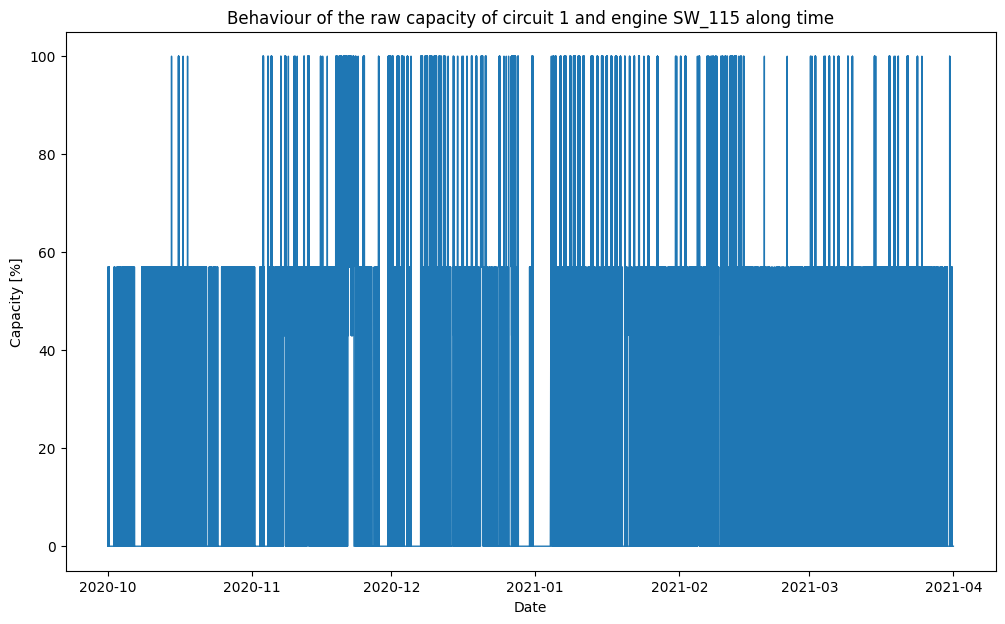

In [21]:
load_percentage_C1_e4 = df_sw115[df_sw115.metric == "S125"].toPandas()
load_percentage_C1_e4["Date"] = pd.to_datetime(load_percentage_C1_e4["when"])

# Plot the raw loading percentage of circuit 1
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
ax.plot(load_percentage_C1_e4["Date"], load_percentage_C1_e4["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 1 and engine SW_115 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [22]:
# Available values of loading percentage in circuit 1
load_percentage_C1_e4 = df_sw115[df_sw115.metric == "S125"]
load_percentage_C1_e4.select(F.col('value')).distinct().collect()

[Row(value=57), Row(value=43), Row(value=0), Row(value=100)]

Text(0, 0.5, 'Capacity [%]')

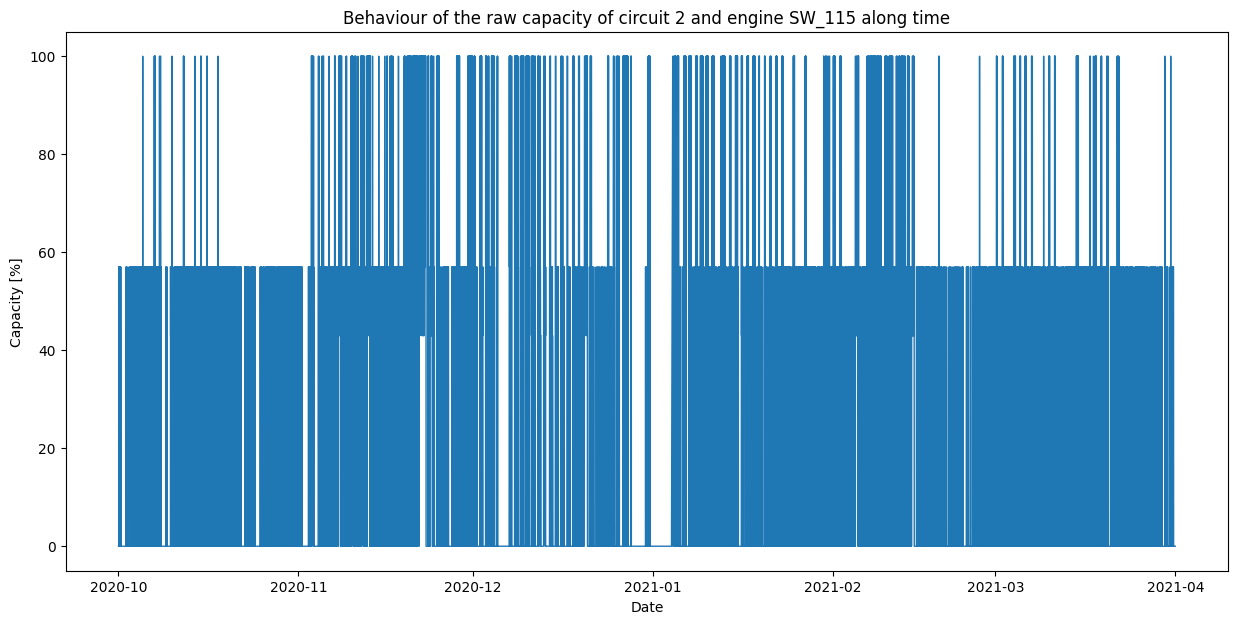

In [23]:
load_percentage_C2_e4 = df_sw115[df_sw115.metric == "S181"].toPandas()
load_percentage_C2_e4["Date"] = pd.to_datetime(load_percentage_C2_e4["when"])

# Plot the raw loading percentage of circuit 2
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(load_percentage_C2_e4["Date"], load_percentage_C2_e4["value"], linewidth=1)
ax.set_title("Behaviour of the raw capacity of circuit 2 and engine SW_115 along time")
ax.set_xlabel("Date")
ax.set_ylabel("Capacity [%]")

In [24]:
# Available values of loading percentage in circuit 2
load_percentage_C2_e4 = df_sw115[df_sw115.metric == "S181"]
load_percentage_C2_e4.select(F.col('value')).distinct().collect()

[Row(value=57), Row(value=43), Row(value=0), Row(value=100)]

Text(0, 0.5, 'External temperature [°C]')

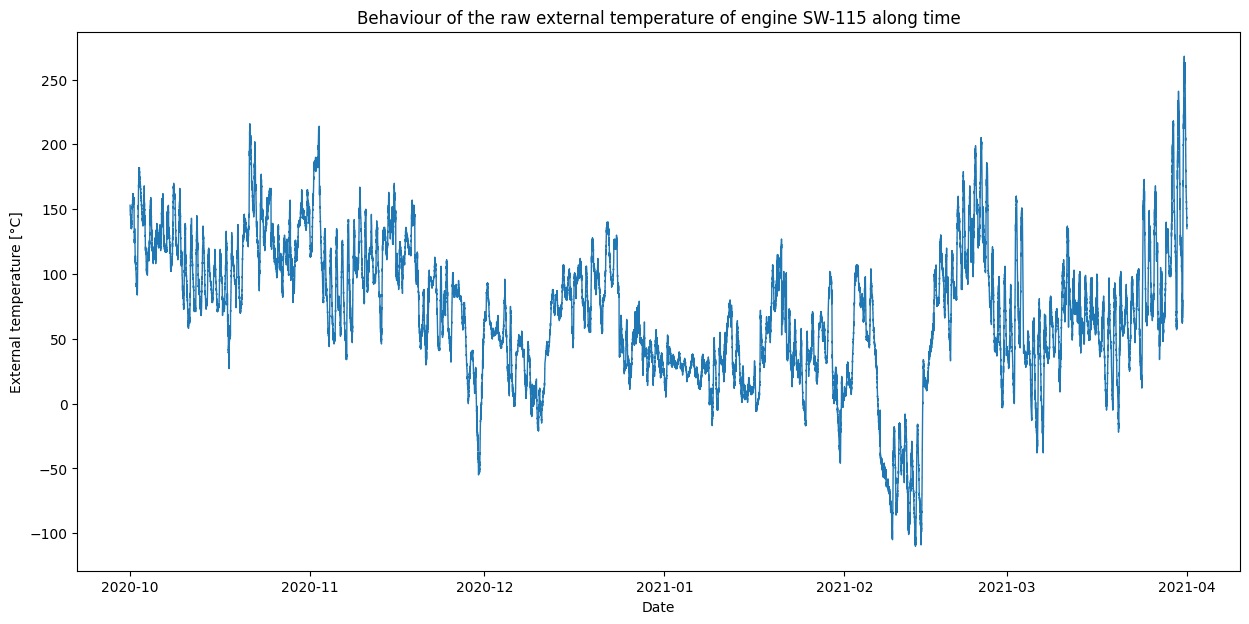

In [25]:
# Select the metric S41 which corresponds to the external temperature in °C
external_temperature_e4 = df_sw115[df_sw115.metric == "S41"].toPandas()
external_temperature_e4["Date"] = pd.to_datetime(external_temperature_e4["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_e4["Date"], external_temperature_e4["value"], linewidth=1)
ax.set_title("Behaviour of the raw external temperature of engine SW-115 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

Text(0, 0.5, 'External temperature [°C]')

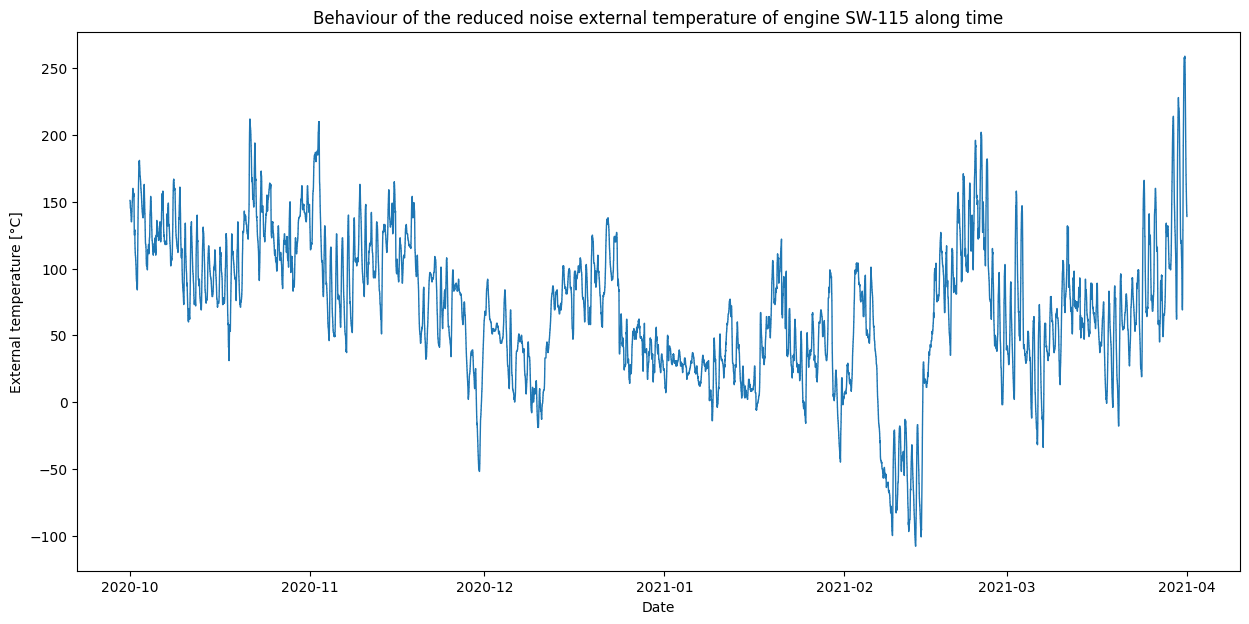

In [26]:
# REMOVE NOISE
window =  Window.partitionBy("metric").orderBy("when").rowsBetween(-50, 50)

xternal_temperature_e4 = df_sw115[df_sw115.metric == "S41"]
external_temperature_without_noise_e4 = xternal_temperature_e4.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when").toPandas()
external_temperature_without_noise_e4["Date"] = pd.to_datetime(external_temperature_without_noise_e4["when"])

# Plot the raw external temperature
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(external_temperature_without_noise_e4['Date'], external_temperature_without_noise_e4['value_without_noise'], linewidth=1)
ax.set_title("Behaviour of the reduced noise external temperature of engine SW-115 along time")
ax.set_xlabel("Date")
ax.set_ylabel("External temperature [°C]")

In [27]:
# NORMALIZATION

# loading percentage of the devices, Circ 1, normalized per HOUR with the feature MAX
percentage_C1_e4_hour = load_percentage_C1_e4.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_percent_C1_e4_max = percentage_C1_e4_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')

# loading percentage of the devices, Circ 2, normalized per HOUR with the feature MAX
percentage_C2_e4_hour = load_percentage_C2_e4.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_percent_C2_e4_max = percentage_C2_e4_hour.groupby('when_hour').agg(F.max('value').alias('value_new')).sort('when_hour')

# external temperature normalized per HOUR with the feature MEAN
xternal_temperature_e4 = df_sw115[df_sw115.metric == "S41"]
external_temperature_without_noise_e4 = xternal_temperature_e4.withColumn("value_without_noise", F.floor(F.avg(F.col("value")).over(window))).sort("when")
external_temperature_e4_hour = external_temperature_without_noise_e4.withColumn("when_hour", F.date_trunc("hour", F.col("when")))
normalized_exTemp_e4_mean = external_temperature_e4_hour.groupby('when_hour').agg(F.ceil(F.mean('value_without_noise')).alias('value_new')).sort('when_hour')


**Analysis of correlations**

In [28]:
## CIRCUIT 1

# make sure no missing values
normalized_percent_C1_e4_max.join(normalized_exTemp_e4_mean, normalized_percent_C1_e4_max.when_hour == normalized_exTemp_e4_mean.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



In [29]:
## CIRCUIT 2

# make sure no missing values 2
normalized_percent_C2_e4_max.join(normalized_exTemp_e4_mean, normalized_percent_C2_e4_max.when_hour == normalized_exTemp_e4_mean.when_hour, how = "leftanti").show()

+---------+---------+
|when_hour|value_new|
+---------+---------+
+---------+---------+



***SUMMARY***

<Axes: >

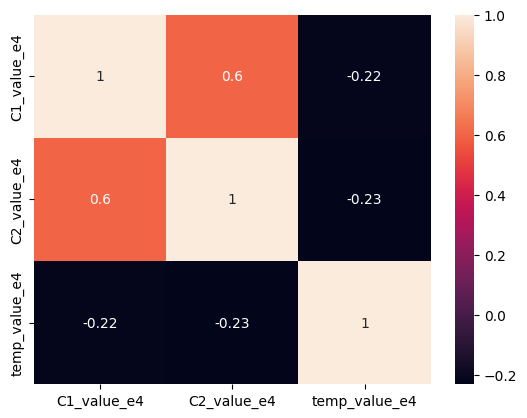

In [30]:
# Heat map of correlations

corr_df_C1T_e4 = normalized_percent_C1_e4_max.withColumnRenamed("value_new", "C1_value_e4").join(normalized_exTemp_e4_mean.withColumnRenamed("value_new", "temp_value_e4"), normalized_percent_C1_e4_max.when_hour == normalized_exTemp_e4_mean.when_hour, "inner")
corr_df_e4 = corr_df_C1T_e4.join(normalized_percent_C2_e4_max.withColumnRenamed("value_new", "C2_value_e4"), normalized_percent_C1_e4_max.when_hour == normalized_percent_C2_e4_max.when_hour, "inner")

corr_e4 = corr_df_e4.select("C1_value_e4", "C2_value_e4", "temp_value_e4").toPandas().corr()

sns.heatmap(corr_e4, annot=True)

Text(0.5, 0, 'Loading percentage [%]')

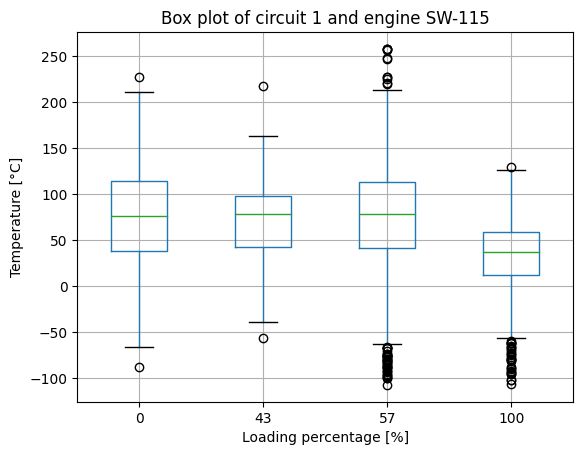

In [31]:
temp_0p_C1_e4 = corr_df_e4[corr_df_e4.C1_value_e4 == 0].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]
temp_43p_C1_e4 = corr_df_e4[corr_df_e4.C1_value_e4 == 43].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]
temp_57p_C1_e4 = corr_df_e4[corr_df_e4.C1_value_e4 == 57].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]
temp_100p_C1_e4 = corr_df_e4[corr_df_e4.C1_value_e4 == 100].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]

temp_C1_e4 = pd.DataFrame({
    "0" : temp_0p_C1_e4,
    "43" : temp_43p_C1_e4,
    "57" : temp_57p_C1_e4,
    "100" : temp_100p_C1_e4
})

boxplot = temp_C1_e4.boxplot(column=['0', '43', '57', '100'])
plt.title("Box plot of circuit 1 and engine SW-115")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")

Text(0.5, 0, 'Loading percentage [%]')

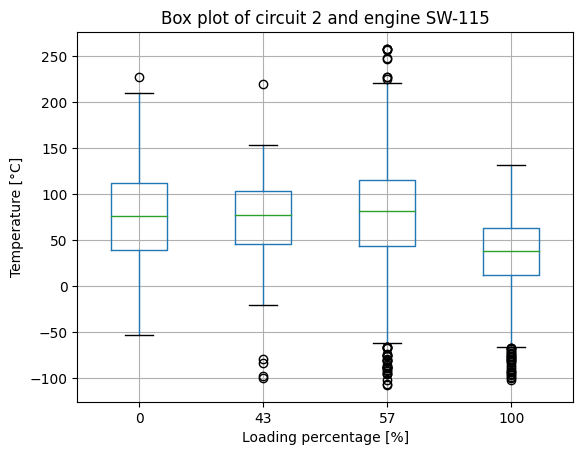

In [32]:
temp_0p_C2_e4 = corr_df_e4[corr_df_e4.C2_value_e4 == 0].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]
temp_43p_C2_e4 = corr_df_e4[corr_df_e4.C2_value_e4 == 43].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]
temp_57p_C2_e4 = corr_df_e4[corr_df_e4.C2_value_e4 == 57].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]
temp_100p_C2_e4 = corr_df_e4[corr_df_e4.C2_value_e4 == 100].select(F.col("temp_value_e4")).toPandas()["temp_value_e4"]

temp_C2_e4 = pd.DataFrame({
    "0" : temp_0p_C2_e4,
    "43" : temp_43p_C2_e4,
    "57" : temp_57p_C2_e4,
    "100" : temp_100p_C2_e4
})

boxplot = temp_C2_e4.boxplot(column=['0', '43', '57', '100'])
plt.title("Box plot of circuit 2 and engine SW-115")
plt.ylabel("Temperature [°C]")
plt.xlabel("Loading percentage [%]")